<a href="https://colab.research.google.com/github/mlvlab/KCCV2022-tutorial/blob/main/02_Human_Object_Interaction_Detection_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlvlab/KCCV2022-tutorial/blob/main/|02_Human_Object_Interaction_Detection_tutorial.ipynb)

# Human-Object Interaction Detection with HOTR

## 실습 내용


1.   HO Pointer 구현
2.   Visualization 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/
!git clone https://github.com/jihwanp/HOTR_-.git

/content/drive/MyDrive
Cloning into 'HOTR_-'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 193 (delta 82), reused 175 (delta 76), pack-reused 0
Receiving objects: 100% (193/193), 25.34 MiB | 9.76 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Checking out files: 100% (54/54), done.


In [ ]:
!pip install wandb
!pip install mmcv

     |████████████████████████████████| 1.7 MB 4.3 MB/s 
     |████████████████████████████████| 181 kB 44.2 MB/s 
     |████████████████████████████████| 144 kB 39.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=c4d0e23fee7647678a3ee41cf91e85aba052e2fab0435d31a9bba1a554ec70f8
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
     |████████████████████████████████| 420 kB 4.3 MB/s 
     |████████████████████████████████| 190 kB 46.6 MB/s 
  Created wheel for mmcv: filename=mmcv-1.4.5-py2.py3-none-any.whl size=627495 sha256=f53ce53f0542713fd3e0e6c0841753e7e0b3a4b37224efec0ab47146840d5fde
  Stored in directory: /root/.cache/pip/wheels/5b/79/26/96dfa214aed0504e9df1569a53474cf505075d5510343f38cf
Successfully built mmcv


## Download pretrained Checkpoint 

In [ ]:
%cd HOTR_-
import os
if not os.path.exists('./checkpoints/vcoco/'):
    os.makedirs('./checkpoints/vcoco/')
# v-coco
!wget -nc https://arena.kakaocdn.net/brainrepo/hotr/vcoco_q16.pth -P ./checkpoints/vcoco/

# if not os.path.exists('./checkpoints/hico-det/'):
#     os.makedirs('./checkpoints/hico-det/')
# # hico-det
# !wget -nc https://arena.kakaocdn.net/brainrepo/hotr/hico_ft_q16.pth -P ./checkpoints/hico-det/

/content/drive/MyDrive/HOTR_-
--2022-02-22 16:26:43--  https://arena.kakaocdn.net/brainrepo/hotr/vcoco_q16.pth
Resolving arena.kakaocdn.net (arena.kakaocdn.net)... 203.217.239.86
Connecting to arena.kakaocdn.net (arena.kakaocdn.net)|203.217.239.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285415416 (272M) [application/zip]
Saving to: ‘./checkpoints/vcoco/vcoco_q16.pth’

vcoco_q16.pth       100%[===================>] 272.19M  17.8MB/s    in 14s     

2022-02-22 16:26:57 (19.6 MB/s) - ‘./checkpoints/vcoco/vcoco_q16.pth’ saved [285415416/285415416]



## HO Pointer 구현 실습

![hopointer](https://drive.google.com/uc?id=1HO8tDMAhcVq8bIDg5M5F6cnHLnEqz4L_)

Formulation for HO Pointer

---

- $\{z_i\}_{i=1}^N$ : interaction representation (N: number of interaction token)
- $\{\bar{v}_i^{\{h,o\}}\}_{i=1}^N $ : normalized interaction representation with projection layer $(= \text{norm}(FFN_{\{h,o\}}(z_i)))$

- $\{\mu_j^{'}\}_{j=1}^K$ : normalized instance representation (K: number of instance token)
- indices of the **instance representations** with the highest similarity scores ($\text{sim}$ : dot-product.)

     $$\hat{c}_i^h=\arg\max_j(\color{red}{\text{sim}(\bar{v}_i^h,\mu^{'}_j)/\tau}) \\\ \hat{c}_i^o=\arg\max_j(\color{red}{\text{sim}(\bar{v}_i^o,\mu^{'}_j)/\tau})$$
  

Variables related to HO Pointer

---

- $FFN_h$ : `FFN_H`
- $FFN_o$ : `FFN_O`
- $\{\mu_j^{'}\}^K_{j=1}$ : `Mu` (dim: batch_size x K x d)
- $\{z_i\}_{i=1}^N$ : `Z` (dim: layer x batch_size x N x d)
- $\tau$ : `tau` (default: 0.05)
- $\{\bar{v}_i^{h}\}_{i=1}^N$ : `VHs`
- $\{\bar{v}_i^{o}\}_{i=1}^N$ : `VOs`


Tips for code (To Do)

---

- similarity score를 구할때 사용하는 representation에 대한 L2 normalize를 해주기 위해 `torch.nn.functional.normalize`를 사용함. (`inst_repr`줄 참고)
- `inst_repr`는 instance decoder의 마지막 layer output embedding을 이용함. 
- 같은 batch안에서 나온 instance representation과 interaction represenation간의 pair-wise similarity를 구하기 위해 `torch.bmm`사용

  *   `torch.bmm`은 두개의 matrix를 input으로 넣어주며 각각 $(b\times n\times m)$, $(b\times m\times p)$의 shape에 맞춰줘야함. 이때문에 interaction representation을 layer마다 나눠서 `torch.bmm`을 사용하여야함.
  *   `tau`를 이용하여 score smoothness 컨트롤

- outputs_hidx,outputs_oidx는 list형식






In [ ]:
# ------------------------------------------------------------------------
# HOTR official code : hotr/models/detr.py
# Copyright (c) Kakao Brain, Inc. and its affiliates. All Rights Reserved
# ------------------------------------------------------------------------
# Modified from DETR (https://github.com/facebookresearch/detr)
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
# ------------------------------------------------------------------------
"""
DETR & HOTR model and criterion classes.
"""
import torch
import torch.nn.functional as F
from torch import nn

from hotr.util.misc import (NestedTensor, nested_tensor_from_tensor_list)

from hotr.models.backbone import build_backbone
from hotr.models.detr_matcher import build_matcher
from hotr.models.hotr_matcher import build_hoi_matcher
from hotr.models.transformer import build_transformer, build_hoi_transformer
from hotr.models.criterion import SetCriterion
from hotr.models.post_process import PostProcess
from hotr.models.feed_forward import MLP
from hotr.models.hotr import HOTR as hotr
from hotr.models.detr import DETR

class HOTR(hotr):
    def __init__(self, detr,
                 num_hoi_queries,
                 num_actions,
                 interaction_transformer,
                 freeze_detr,
                 share_enc,
                 pretrained_dec,
                 temperature,
                 hoi_aux_loss,
                 return_obj_class=None):
        super().__init__(detr,
                 num_hoi_queries,
                 num_actions,
                 interaction_transformer,
                 freeze_detr,
                 share_enc,
                 pretrained_dec,
                 temperature,
                 hoi_aux_loss,
                 return_obj_class)
        hidden_dim=detr.transformer.d_model
        self.H_Pointer_embed   = MLP(hidden_dim, hidden_dim, hidden_dim, 3)
        self.O_Pointer_embed   = MLP(hidden_dim, hidden_dim, hidden_dim, 3)
        self.tau = temperature
        
    def forward(self, samples: NestedTensor):
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        
        # >>>>>>>>>>>>  BACKBONE LAYERS  <<<<<<<<<<<<<<<
        features, pos = self.detr.backbone(samples)
        bs = features[-1].tensors.shape[0]
        src, mask = features[-1].decompose()
        assert mask is not None
        # ----------------------------------------------

        # >>>>>>>>>>>> OBJECT DETECTION LAYERS <<<<<<<<<<
        start_time = time.time()
        hs, _ = self.detr.transformer(self.detr.input_proj(src), mask, self.detr.query_embed.weight, pos[-1])
        inst_repr = F.normalize(hs[-1], p=2, dim=2) # instance representations

        # Prediction Heads for Object Detection
        outputs_class = self.detr.class_embed(hs)
        outputs_coord = self.detr.bbox_embed(hs).sigmoid()
        object_detection_time = time.time() - start_time
        # -----------------------------------------------

        # >>>>>>>>>>>> HOI DETECTION LAYERS <<<<<<<<<<<<<<<
        start_time = time.time()
        assert hasattr(self, 'interaction_transformer'), "Missing Interaction Transformer."
        interaction_hs = self.interaction_transformer(self.detr.input_proj(src), mask, self.query_embed.weight, pos[-1])[0] # interaction representations
    
        ## Variables for HO Pointer
        FFN_H = self.H_Pointer_embed # output dim: R^d -> R^d
        FFN_O = self.O_Pointer_embed # output dim: R^d -> R^d
        Z = interaction_hs # layer x batch_size x N x d
        Mu = inst_repr # batch_size x K x d
        ##

        # #[HO Pointers]
        #-------------------------------------To Do-------------------------------------
        # **{functionality description}** 을 채워주세요. 
        VHs = **normalize function**(**human_ffn**(**interaction representation**), p=2, dim=-1) #interaction decoder의 output을 projection시킨후 normalize (output dim: layer x batch_size x N x d)
        VOs = **normalize function**(**object_ffn**(**interaction representation**), p=2, dim=-1) #interaction decoder의 output을 projection시킨후 normalize (output dim: layer x batch_size x N x d)
        outputs_hidx = [(**batch matmul function**(**H Pointer representation at each layer**, **instance representation**)) / **temperature** for **H Pointer representation at each layer** in VHs] #Human representation 과 instance representation간의 logit matrix를 계산 (output dim: layer x batch_size x N x K)
        outputs_oidx = [(**batch matmul function**(**O Pointer representation at each layer**, **instance representation**)) / **temperature** for **O Pointer representation at each layer** in VOs] #Object representation 과 instance representation간의 logit matrix를 계산 (output dim: layer x batch_size x N x K)
        #-------------------------------------------------------------------------------
        

        # [Action Classification]
        outputs_action = self.action_embed(interaction_hs)
        # --------------------------------------------------
        hoi_detection_time = time.time() - start_time
        hoi_recognition_time = max(hoi_detection_time - object_detection_time, 0)
        # -------------------------------------------------------------------

        # [Target Classification]
        if self.return_obj_class:
            detr_logits = outputs_class[-1, ..., self._valid_obj_ids]
            o_indices = [output_oidx.max(-1)[-1] for output_oidx in outputs_oidx]
            obj_logit_stack = [torch.stack([detr_logits[batch_, o_idx, :] for batch_, o_idx in enumerate(o_indice)], 0) for o_indice in o_indices]
            outputs_obj_class = obj_logit_stack

        out = {
            "pred_logits": outputs_class[-1],
            "pred_boxes": outputs_coord[-1],
            "pred_hidx": outputs_hidx[-1],
            "pred_oidx": outputs_oidx[-1],
            "pred_actions": outputs_action[-1],
            "hoi_recognition_time": hoi_recognition_time,
        }

        if self.return_obj_class: out["pred_obj_logits"] = outputs_obj_class[-1]

        if self.hoi_aux_loss: # auxiliary loss
            out['hoi_aux_outputs'] = \
                self._set_aux_loss_with_tgt(outputs_class, outputs_coord, outputs_hidx, outputs_oidx, outputs_action, outputs_obj_class) \
                if self.return_obj_class else \
                self._set_aux_loss(outputs_class, outputs_coord, outputs_hidx, outputs_oidx, outputs_action)

        return out

def build_model(args):
    device = torch.device(args.device)

    backbone = build_backbone(args)

    transformer = build_transformer(args)

    model = DETR(
        backbone,
        transformer,
        num_classes=args.num_classes,
        num_queries=args.num_queries,
        aux_loss=args.aux_loss,
    )

    matcher = build_matcher(args)
    weight_dict = {'loss_ce': 1, 'loss_bbox': args.bbox_loss_coef}
    weight_dict['loss_giou'] = args.giou_loss_coef

    # TODO this is a hack
    if args.aux_loss:
        aux_weight_dict = {}
        for i in range(args.dec_layers - 1):
            aux_weight_dict.update({k + f'_{i}': v for k, v in weight_dict.items()})
        weight_dict.update(aux_weight_dict)

    losses = ['labels', 'boxes', 'cardinality'] if args.frozen_weights is None else []
    if args.HOIDet:
        hoi_matcher = build_hoi_matcher(args)
        hoi_losses = []
        hoi_losses.append('pair_labels')
        hoi_losses.append('pair_actions')
        if args.dataset_file == 'hico-det': hoi_losses.append('pair_targets')
        
        hoi_weight_dict={}
        hoi_weight_dict['loss_hidx'] = args.hoi_idx_loss_coef
        hoi_weight_dict['loss_oidx'] = args.hoi_idx_loss_coef
        hoi_weight_dict['loss_act'] = args.hoi_act_loss_coef
        if args.dataset_file == 'hico-det': hoi_weight_dict['loss_tgt'] = args.hoi_tgt_loss_coef
        if args.hoi_aux_loss:
            hoi_aux_weight_dict = {}
            for i in range(args.hoi_dec_layers):
                hoi_aux_weight_dict.update({k + f'_{i}': v for k, v in hoi_weight_dict.items()})
            hoi_weight_dict.update(hoi_aux_weight_dict)

        criterion = SetCriterion(args.num_classes, matcher=matcher, weight_dict=hoi_weight_dict,
                                 eos_coef=args.eos_coef, losses=losses, num_actions=args.num_actions,
                                 HOI_losses=hoi_losses, HOI_matcher=hoi_matcher, args=args)

        interaction_transformer = build_hoi_transformer(args) # if (args.share_enc and args.pretrained_dec) else None

        kwargs = {}
        if args.dataset_file == 'hico-det': kwargs['return_obj_class'] = args.valid_obj_ids
        model = HOTR(
            detr=model,
            num_hoi_queries=args.num_hoi_queries,
            num_actions=args.num_actions,
            interaction_transformer=interaction_transformer,
            freeze_detr=(args.frozen_weights is not None),
            share_enc=args.share_enc,
            pretrained_dec=args.pretrained_dec,
            temperature=args.temperature,
            hoi_aux_loss=args.hoi_aux_loss,
            **kwargs # only return verb class for HICO-DET dataset
        )
        postprocessors = {'hoi': PostProcess(args.HOIDet)}
    else:
        criterion = SetCriterion(args.num_classes, matcher=matcher, weight_dict=weight_dict,
                                 eos_coef=args.eos_coef, losses=losses)
        postprocessors = {'bbox': PostProcess(args.HOIDet)}
    criterion.to(device)

    return model, criterion, postprocessors

#### HO Pointer code solution



        VHs = F.normalize(FFN_H(Z), dim=-1) 
        VOs = F.normalize(FFN_O(Z), dim=-1)
        outputs_hidx = [torch.bmm(VH, Mu.transpose(1,2))/self.tau for VH in VHs]  
        outputs_oidx = [torch.bmm(VO, Mu.transpose(1,2))/self.tau for VO in VOs]

## Visualization Code

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import cv2


vcoco_action_string = {2: 'hold', 3: 'stand', 4: 'sit', 5: 'ride', 6: 'walk',\
                       7: 'look', 8: 'hit_inst', 9: 'hit_obj', 10: 'eat_obj', \
                       11: 'eat_inst', 12: 'jump', 13: 'lay', 14: 'talk', 15: \
                       'carry', 16: 'throw', 17: 'catch', 18: 'cut_inst', 19:'cut_obj', \
                       20: 'run', 21: 'work_on_comp', 22: 'ski', 23: 'surf', 24: 'skateboard', \
                       25: 'smile', 26: 'drink', 27: 'kick', 28: 'point', 29: 'read', 30: 'snowboard'}
def draw_box_on_img(box, img,color=None):

    vis_img = img.copy()
    box = [int(x) for x in box]
    cv2.rectangle(vis_img, (box[0], box[1]), (box[2], box[3]), color, 2)
    draw_point=[int((box[0]+box[2])*1.0/2),int((box[1]+box[3])*1.0/2)]
    
    return vis_img,color


def draw_line_on_img_vcoco(box,line, img, class_index,color):
    
    vis_img = img.copy()
    font=cv2.FONT_HERSHEY_SIMPLEX
    x=int(box[0])+2
    y=int(box[1])+2
    f=int(box[1])+2
    for i in range(len(class_index)):
     
        font_scale=1
        font_thickness=2
    
        text_size, _ = cv2.getTextSize(vcoco_action_string[class_index[i]] , font, font_scale, font_thickness)
        vis_img=cv2.rectangle(vis_img,(x,y),(x+text_size[0],y+text_size[1]+5),color[1],-1)
        

        vis_img=cv2.putText(vis_img, vcoco_action_string[class_index[i]] ,(x,y + text_size[1] ),font,font_scale,[51,255,153],font_thickness)
        y=y+text_size[1]+5
   
    return vis_img,y


def draw_img_vcoco(img, output_i, top_k,threshold,color):
    list_action = []
    for action in output_i['hoi_prediction']:
        subject_id = action['subject_id']
        object_id = action['object_id']
        category_id = action['category_id']
        score = action['score']
        single_out = [subject_id,object_id,category_id,score]
        list_action.append(single_out)
    list_action = sorted(list_action, key=lambda x:x[-1], reverse=True)
    action_dict = []
    action_cate = []
    action_color=[]
    subj_box=[]
    sb={}
    sbj=[]
    for action in list_action[:top_k]:

        subject_id,object_id,category_id,score = action
        if score<threshold:
            break
        subject_obj = output_i['predictions'][subject_id]
        subject_box = subject_obj['bbox']
        object_obj = output_i['predictions'][object_id]
        object_box = object_obj['bbox']

        point_1 = [int((subject_box[0]+subject_box[2])*1.0/2),int((subject_box[1]+subject_box[3])*1.0/2)]
        point_2 = [int((object_box[0]+object_box[2])*1.0/2),int((object_box[1]+object_box[3])*1.0/2)]
  
        if [point_1,point_2] not in action_dict:
            
            img,color_hum = draw_box_on_img(subject_box, img, color[subject_obj['category_id']]['color'])
            
            img,color_obj = draw_box_on_img(object_box, img, color[object_obj['category_id']]['color'])
            
            action_dict.append([point_1,point_2])
            action_color.append([color_hum,color_obj])
            subj_box.append([int(subject_box[0]),int(subject_box[1])])    
           
        action_cate.append([])
        action_cate[action_dict.index([point_1,point_2])].append(category_id)

    for i,(action_item,clr) in enumerate(zip(action_dict,action_color)):
        
        img,offset = draw_line_on_img_vcoco(subj_box[i],action_item,img,action_cate[action_dict.index(action_item)],clr)

        for p in range(i+1,len(subj_box)):
            if subj_box[p]==subj_box[i]:
                subj_box[p][1]=offset
    return img

In [ ]:
import argparse
import datetime
import json
import random
import time
import multiprocessing
from pathlib import Path
import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
import hotr.data.datasets as datasets
import hotr.util.misc as utils
from hotr.engine.arg_parser import get_args_parser
from hotr.data.datasets import build_dataset, get_coco_api_from_dataset
from hotr.data.datasets.vcoco import make_hoi_transforms
from PIL import Image
from hotr.util.logger import print_params, print_args

import copy
from hotr.data.datasets import builtin_meta
from PIL import Image
import requests
import mmcv
from matplotlib import pyplot as plt
import imageio

def change_format(results,valid_ids):
    
    boxes,labels,pair_score =\
                    list(map(lambda x: x.cpu().numpy(), [results['boxes'], results['labels'], results['pair_score']]))
    output_i={}
    output_i['predictions']=[]
    output_i['hoi_prediction']=[]

    h_idx=np.where(labels==1)[0]
    for box,label in zip(boxes,labels):
        
        output_i['predictions'].append({'bbox':box.tolist(),'category_id':label})
    
    for i,verb in enumerate(pair_score):
        if i in [1,4,10,23,26,5,18]:
            continue
        for j,hum in enumerate(h_idx):
            for k in range(len(boxes)):
                if verb[j][k]>0:
                    output_i['hoi_prediction'].append({'subject_id':hum,'object_id':k,'category_id':i+2,'score':verb[j][k]})
            
    return output_i
def vis(args,id=294):

    if args.frozen_weights is not None:
        print("Freeze weights for detector")

    device = torch.device(args.device)

    # fix the seed for reproducibility
    seed = args.seed + utils.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Data Setup
    dataset_train = build_dataset(image_set='train', args=args)
    args.num_classes = dataset_train.num_category()
    args.num_actions = dataset_train.num_action()
    args.action_names = dataset_train.get_actions()
    if args.share_enc: args.hoi_enc_layers = args.enc_layers
    if args.pretrained_dec: args.hoi_dec_layers = args.dec_layers
    if args.dataset_file == 'vcoco':
        # Save V-COCO dataset statistics
        args.valid_ids = np.array(dataset_train.get_object_label_idx()).nonzero()[0]
        args.invalid_ids = np.argwhere(np.array(dataset_train.get_object_label_idx()) == 0).squeeze(1)
        args.human_actions = dataset_train.get_human_action()
        args.object_actions = dataset_train.get_object_action()
        args.num_human_act = dataset_train.num_human_act()
    elif args.dataset_file == 'hico-det':
        args.valid_obj_ids = dataset_train.get_valid_obj_ids()
    print_args(args)

    args.HOIDet=True
    args.eval=True
    args.pretrained_dec=True
    args.share_enc=True
    if args.dataset_file=='hico-det':
        args.valid_ids=args.valid_obj_ids
 
    # Model Setup
    model, criterion, postprocessors = build_model(args)
    model.to(device)

    model_without_ddp = model

    n_parameters = print_params(model)

    param_dicts = [
        {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": args.lr_backbone,
        },
    ]

    output_dir = Path(args.output_dir)
    
    checkpoint = torch.load(args.resume, map_location='cpu')
    #수정
    module_name=list(checkpoint['model'].keys())
    model_without_ddp.load_state_dict(checkpoint['model'], strict=False)
    
    if not args.video_vis:
        url='http://images.cocodataset.org/val2014/COCO_val2014_{}.jpg'.format(str(id).zfill(12))
        req = requests.get(url, stream=True, timeout=1, verify=False).raw
        img = Image.open(req).convert('RGB')

        w,h=img.size
        orig_size = torch.as_tensor([int(h), int(w)]).unsqueeze(0).to(device)

        transform=make_hoi_transforms('val')
        sample=img.copy()
        sample,_=transform(sample,None)
        sample = sample.unsqueeze(0).to(device)
        with torch.no_grad():
            model.eval()
            out=model(sample)
            results = postprocessors['hoi'](out, orig_size,dataset=args.dataset_file)
            output_i=change_format(results[0],args.valid_ids)

        out_dir = './vis'
        image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
        image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)

        vis_img=draw_img_vcoco(image,output_i,top_k=args.topk,threshold=args.threshold,color=builtin_meta.COCO_CATEGORIES)        
        plt.imshow(cv2.cvtColor(vis_img,cv2.COLOR_BGR2RGB))
    else:
        frames=[]
        video_file='tri_cut'
    
        video_reader = mmcv.VideoReader('./vid/'+video_file+'.mp4')
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video_writer = cv2.VideoWriter(
                './vid/'+video_file+'_vis.mp4', fourcc, video_reader.fps,
                (video_reader.width, video_reader.height))

        orig_size = torch.as_tensor([int(video_reader.height), int(video_reader.width)]).unsqueeze(0).to(device)
        transform=make_hoi_transforms('val')

        for frame in mmcv.track_iter_progress(video_reader):

            frame=mmcv.imread(frame)
            frame=frame.copy()
  
            frame=Image.fromarray(frame,'RGB')

            sample,_=transform(frame,None)
            sample=sample.unsqueeze(0).to(device)

            with torch.no_grad():
                model.eval()
                out=model(sample)
                results = postprocessors['hoi'](out, orig_size,dataset='vcoco')
                output_i=change_format(results[0],args.valid_ids)

            vis_img=draw_img_vcoco(np.array(frame),output_i,top_k=args.topk,threshold=args.threshold,color=builtin_meta.COCO_CATEGORIES)
            frames.append(vis_img)
            video_writer.write(vis_img)

        with imageio.get_writer("smiling.gif", mode="I") as writer:
            for idx, frame in enumerate(frames):
                # print("Adding frame to GIF file: ", idx + 1)
                writer.append_data(frame)
        if video_writer:
            video_writer.release()
        cv2.destroyAllWindows()
 

def visualization(id, video_vis=False, dataset_file='vcoco', data_path='v-coco', threshold=0.4, topk=10):

    parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
    checkpoint_dir= './checkpoints/vcoco/vcoco_q16.pth' if dataset_file=='vcoco' else './checkpoints/hico-det/hico_ft_q16.pth'
    with open('./v-coco/data/vcoco_test.ids') as file:
      test_idxs = [line.rstrip('\n') for line in file]
    if id is not None:
      id = test_idxs[id]
    args = parser.parse_args(args=['--dataset_file',dataset_file,'--data_path',data_path,'--resume',checkpoint_dir,'--num_hoi_queries' ,'16','--temperature' ,'0.05' ])
    args.video_vis=video_vis
    args.threshold=threshold
    args.topk=topk
    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    vis(args,id)


## Visualize Image & Video
- `video_vis` : visualize video if True else image
- `threshold`: HOI triplet score threshold
- `topk`: visualize topk predictions where the scores are above threshold

loading annotations into memory...
Done (t=2.27s)
creating index...
index created!

[Logger] DETR Arguments:
	lr: 0.0001
	lr_backbone: 1e-05
	lr_drop: 80
	frozen_weights: None
	backbone: resnet50
	dilation: False
	position_embedding: sine
	enc_layers: 6
	dec_layers: 6
	num_queries: 100
	dataset_file: vcoco


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]


[Logger] Number of params:  51181950


/content/drive/MyDrive/HOTR_-/hotr/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


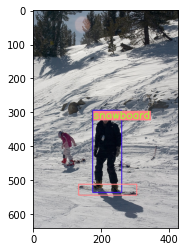

In [ ]:
visualization(id=309,dataset_file='vcoco',data_path='v-coco')  

loading annotations into memory...
Done (t=1.95s)
creating index...
index created!

[Logger] DETR Arguments:
	lr: 0.0001
	lr_backbone: 1e-05
	lr_drop: 80
	frozen_weights: None
	backbone: resnet50
	dilation: False
	position_embedding: sine
	enc_layers: 6
	dec_layers: 6
	num_queries: 100
	dataset_file: vcoco

[Logger] Number of params:  51181950


/content/drive/MyDrive/HOTR_-/hotr/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


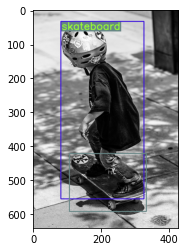

In [ ]:
visualization(id=162,dataset_file='vcoco',data_path='v-coco') 

In [ ]:
if not os.path.exists('./vid/'):
    os.makedirs('./vid/')
!wget -nc "https://drive.google.com/uc?id=1JoO08dgvQ-tCP-OxDbTDUH1e83MkkF3Z" -O ./vid/tri_cut.mp4

--2022-02-22 16:28:00--  https://drive.google.com/uc?id=1JoO08dgvQ-tCP-OxDbTDUH1e83MkkF3Z
Resolving drive.google.com (drive.google.com)... 142.250.157.101, 142.250.157.102, 142.250.157.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.157.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nip5stoocoobv90hurll1rmgnsuoouov/1645547250000/04510992398135305556/*/1JoO08dgvQ-tCP-OxDbTDUH1e83MkkF3Z [following]
--2022-02-22 16:28:01--  https://doc-10-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nip5stoocoobv90hurll1rmgnsuoouov/1645547250000/04510992398135305556/*/1JoO08dgvQ-tCP-OxDbTDUH1e83MkkF3Z
Resolving doc-10-as-docs.googleusercontent.com (doc-10-as-docs.googleusercontent.com)... 142.250.157.132, 2404:6800:4008:c13::84
Connecting to doc-10-as-docs.googleusercontent.com (doc-10-as-docs.googleusercontent.com)|142.250.1

In [ ]:
visualization(id=None,video_vis=True,dataset_file='vcoco',data_path='v-coco')

loading annotations into memory...
Done (t=2.13s)
creating index...
index created!

[Logger] DETR Arguments:
	lr: 0.0001
	lr_backbone: 1e-05
	lr_drop: 80
	frozen_weights: None
	backbone: resnet50
	dilation: False
	position_embedding: sine
	enc_layers: 6
	dec_layers: 6
	num_queries: 100
	dataset_file: vcoco

[Logger] Number of params:  51181950
[                                                  ] 0/58, elapsed: 0s, ETA:

/content/drive/MyDrive/HOTR_-/hotr/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 58/58, 1.6 task/s, elapsed: 37s, ETA:     0s


### GIF format

In [ ]:
import imageio
file_name='tri_cut_vis.mp4'
fps=(mmcv.VideoReader('./vid/'+file_name)).fps
cap = cv2.VideoCapture('./vid/'+file_name)
image_lst = []
 
while True:
    ret, frame = cap.read()
    if frame is None: 
      break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_lst.append(frame_rgb)
    
    # cv2.imshow('a', frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
 
# Convert to gif using the imageio.mimsave method
imageio.mimsave('./vid/tri_cut_vis.gif', image_lst, fps=fps)


In [ ]:
from IPython import display
gifPath = Path('./vid/tri_cut_vis.gif') # please paste the whole path from Step 2-6
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')